In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import pandas
from IPython.display import Image
from IPython.display import display
import copy

In [3]:
def computeInterCluster(R):
    iloczynySkalarne = -2*np.dot(R.T, R)
    kwadratyDlugosci = np.sum(R**2, axis=0, keepdims=True)
    iloczynySkalarne += kwadratyDlugosci
    iloczynySkalarne += kwadratyDlugosci.T

    return iloczynySkalarne

def computeIntraClusterDistances(data, C, R, I, K, N):
    swojeCentra = np.take(R, C, axis=1)
    swojeCentra -= data
    swojeCentra **= 2

    intraClusterDistances = np.sqrt(np.sum(swojeCentra, axis=0, keepdims=True))

    liczebnosc = np.zeros(K)
    intraAvg = np.zeros(K)
    intraMax = np.zeros(K)
    
    for i in range(N):
        intraAvg[C[i]] += intraClusterDistances[0][i]
        intraMax[C[i]] = max(intraClusterDistances[0][i], intraMax[C[i]])
        liczebnosc[C[i]] += 1
    
    intraAvg /= np.maximum(liczebnosc, 1)
    
    return (intraAvg, intraMax)
        
    

def KMeans(K, data, printInfo=False):
    d = np.size(data, axis=0)
    N = np.size(data, axis=1)
    I = np.eye(K)
    
    #Centra grup (losowe wektory z danych)
    #R = np.take(data, np.random.choice(np.arange(0,N), K, replace=False), axis=1)
    R = np.empty([d,K])
    choices = np.random.choice(np.arange(0,N), K, replace=False)
    for i in range(K):
        R[:,i] = data[:, choices[i]]
    #Przynależnosc do grupy (na poczatku wszyscy do zero)
    C = np.zeros((1,N), dtype=np.int64)
    macierPrzynaleznosci = None

    iteration = 0
    groupsChanged = True
    while groupsChanged:
        iteration += 1
        #Interesuje nas minimalna wartość <r,r> -2<u,r>, gdzie u to wektor z danych a r to jakies centrum
        iloczynySkalarne = -2. * np.dot(data.T, R)
        R**=2
        kwadratyDlugosciR = np.sum(R, axis=0, keepdims=True)
        iloczynySkalarne += kwadratyDlugosciR

        #Dla kazdego wektora z danych wybieramy najblizszy wektor z R i aktualizujemy grupy
        newC = np.argmin(iloczynySkalarne, axis=1)
        groupsChanged = not np.array_equal(C, newC)
        C = newC

        #Obliczamy srodki ciezkosci dla kazdej grupy
        macierzPrzynaleznosci = np.take(I, C, axis=0)
        #Sumy danych w każdej z grup
        R = np.dot(data, macierzPrzynaleznosci)
        liczebnosciGrup = np.maximum(np.sum(macierzPrzynaleznosci, axis=0, keepdims=True), 1)
        R /= liczebnosciGrup

    #Liczymy wielkosci grup, odleglosci miedzy grupami, srednie i najwieksze odleglosci w grupach
    groupSizes = np.sum(macierzPrzynaleznosci, axis=0).astype(np.int64)
    interCluster = computeInterCluster(R)
    intraClusterAvg, intraClusterMax = computeIntraClusterDistances(data, C, R, I, K, N)
    
    if printInfo:
        print("Iterations:", iteration, "\n")
        print("Group sizes:\n", groupSizes, "\n")
        print("Inter cluster distances:")
        print(interCluster, "\n")
        print("Intra cluster average distance to center\n", intraClusterAvg, "\n")
        print("Intra cluster maximum distance to center\n", intraClusterMax, "\n")
    
    return (C, R, interCluster, intraClusterAvg, intraClusterMax)

In [124]:
def compareClustersWithResuls(groups, K, results):
    differentResults = {result:0 for result in results}
    groupResults = [copy.deepcopy(differentResults) for i in range(K)]
    groupSizes = [0 for i in range(K)]
    for i in range(len(groups)):
        groupSizes[groups[i]] += 1
        groupResults[groups[i]][results[i]] += 1
    
    for i in range(K):
        for result in groupResults[i]:
            groupResults[i][result] *= (100/groupSizes[i])
        print("Group:", i, "| Size:", groupSizes[i], "| Results:", groupResults[i])


# Iris dataset

Iterations: 6 

Group sizes:
 [39 50 61] 

Inter cluster distances:
[[  0.00000000e+00   2.48806831e+01   3.19845877e+00]
 [  2.48806831e+01   0.00000000e+00   1.11985032e+01]
 [  3.19845877e+00   1.11985032e+01   1.42108547e-14]] 

Intra cluster average distance to center
 [ 0.73184588  0.48413225  0.73110849] 

Intra cluster maximum distance to center
 [ 1.55155963  1.23935144  1.64680107] 



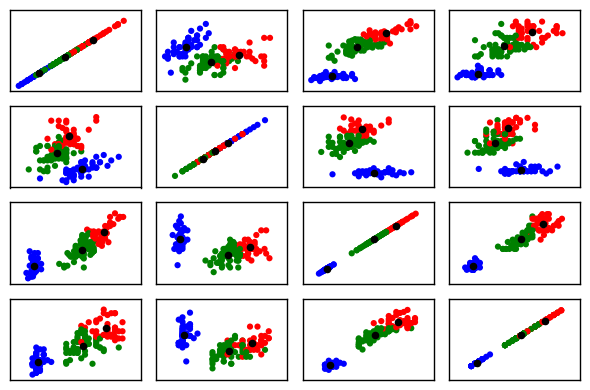

Group: 0 | Size: 39 | Results: {'Iris-virginica': 92.30769230769232, 'Iris-versicolor': 7.692307692307693, 'Iris-setosa': 0.0}
Group: 1 | Size: 50 | Results: {'Iris-virginica': 0.0, 'Iris-versicolor': 0.0, 'Iris-setosa': 100.0}
Group: 2 | Size: 61 | Results: {'Iris-virginica': 22.950819672131146, 'Iris-versicolor': 77.04918032786885, 'Iris-setosa': 0.0}


In [125]:
originalData = pandas.read_csv('iris/iris.data', sep=',', header=None)

irisData = originalData.ix[:,:3].values.T

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(3, irisData, printInfo=True)

colormap={0: 'Red', 1:'Blue', 2:'Green'}
d = irisData.shape[0]

for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i*d+j+1)
        plt.scatter(irisData[i, :], irisData[j, :], c=[colormap[k] for k in groups], marker='o', lw = 0)
        plt.scatter(centers[i,:], centers[j,:], c="Black", marker='o', lw = 1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

#for i in range(irisData.shape[1]):
#    print("Id:", i, "Group:", groups[i], "Species:", originalData.ix[i,4])
    
compareClustersWithResuls(groups, 3, originalData.ix[:,4])

# Wine dataset

## Not normalized data - 3 groups

Iterations: 5 

Group sizes:
 [102  49  27] 

Inter cluster distances:
[[  0.00000000e+00   1.48304783e+05   6.19878305e+05]
 [  1.48304783e+05  -2.32830644e-10   1.61968065e+05]
 [  6.19878305e+05   1.61968065e+05   0.00000000e+00]] 

Intra cluster average distance to center
 [  97.81568838  114.28332172  105.92107744] 

Intra cluster maximum distance to center
 [ 243.7039893   198.9671698   371.23927336] 



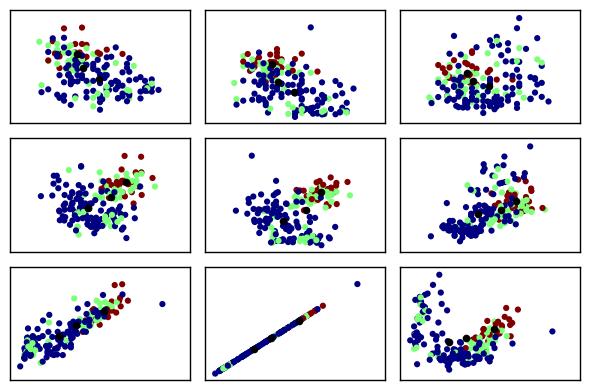

Group: 0 | Size: 102 | Results: {1: 0.9803921568627451, 2: 62.745098039215684, 3: 36.27450980392157}
Group: 1 | Size: 49 | Results: {1: 63.26530612244898, 2: 14.285714285714286, 3: 22.448979591836736}
Group: 2 | Size: 27 | Results: {1: 100.0, 2: 0.0, 3: 0.0}


In [128]:
originalData = pandas.read_csv('wine/wine.data', sep=',', header=None)
analysisData = originalData.ix[:,1:].values.T

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(3, analysisData, printInfo=True)

d = analysisData.shape[0]
x = np.random.choice(np.arange(0,d), size=3, replace=False)
y = np.random.choice(np.arange(0,d), size=3, replace=False)
d = 3
for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i*d+j+1)
        plt.scatter(analysisData[x[i], :], analysisData[y[j], :], c=groups, marker='o', lw = 0)
        plt.scatter(centers[x[i],:], centers[y[j],:], c="Black", marker='o', lw = 1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

#for i in range(analysisData.shape[1]):
#    print("Id:", i, "Group:", groups[i], "Wine type:", originalData.ix[i,0])

compareClustersWithResuls(groups, 3, originalData.ix[:,0])

## Dwie grupy - znormalizowane dane

Iterations: 16 

Group sizes:
 [ 70 108] 

Inter cluster distances:
[[ 0.          0.73135093]
 [ 0.73135093  0.        ]] 

Intra cluster average distance to center
 [ 0.5718014  0.5865641] 

Intra cluster maximum distance to center
 [ 1.06922816  1.10775377] 



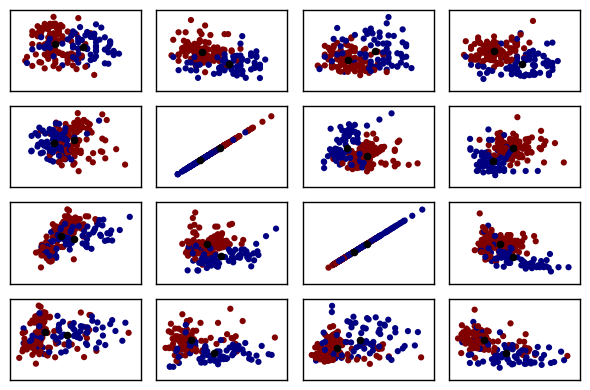

Group: 0 | Size: 70 | Results: {1: 0.0, 2: 31.42857142857143, 3: 68.57142857142857}
Group: 1 | Size: 108 | Results: {1: 54.62962962962963, 2: 45.370370370370374, 3: 0.0}


In [129]:
originalData = pandas.read_csv('wine/wine.data', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values
analysisData = (analysisData - analysisData.mean(axis=1, keepdims=True)) / (analysisData.max(axis=1, keepdims=True) - analysisData.min(axis=1, keepdims=True))

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(2, analysisData, printInfo=True)

d = analysisData.shape[0]
x = np.random.choice(np.arange(0,d), size=4, replace=False)
y = np.random.choice(np.arange(0,d), size=4, replace=False)
d = 4
for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i*d+j+1)
        plt.scatter(analysisData[x[i], :], analysisData[y[j], :], c=groups, marker='o', lw = 0)
        plt.scatter(centers[x[i],:], centers[y[j],:], c="Black", marker='o', lw = 1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

compareClustersWithResuls(groups, 2, originalData.ix[:,0])

## Trzy grupy
Optymalnie i trafiamy w prawdziwe typy wina

Iterations: 5 

Group sizes:
 [65 54 59] 

Inter cluster distances:
[[  0.00000000e+00   1.14602190e+00   5.51673994e-01]
 [  1.14602190e+00   0.00000000e+00   6.76013144e-01]
 [  5.51673994e-01   6.76013144e-01   5.55111512e-17]] 

Intra cluster average distance to center
 [ 0.45846487  0.50699909  0.53558796] 

Intra cluster maximum distance to center
 [ 0.90692795  0.98278791  1.13579938] 



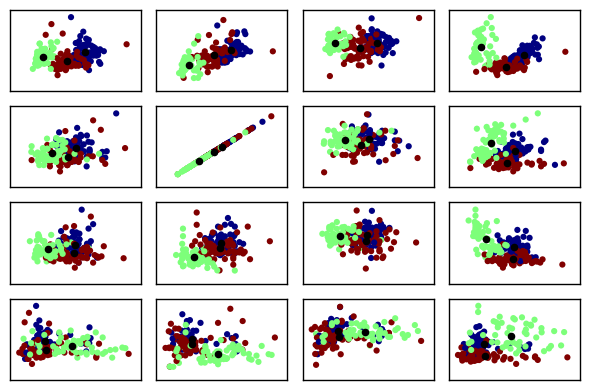

Group: 0 | Size: 65 | Results: {1: 90.76923076923077, 2: 9.230769230769232, 3: 0.0}
Group: 1 | Size: 54 | Results: {1: 0.0, 2: 11.11111111111111, 3: 88.88888888888889}
Group: 2 | Size: 59 | Results: {1: 0.0, 2: 100.0, 3: 0.0}


In [130]:
originalData = pandas.read_csv('wine/wine.data', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values
analysisData = (analysisData - analysisData.mean(axis=1, keepdims=True)) / (analysisData.max(axis=1, keepdims=True) - analysisData.min(axis=1, keepdims=True))

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(3, analysisData, printInfo=True)

d = analysisData.shape[0]
x = np.random.choice(np.arange(0,d), size=4, replace=False)
y = np.random.choice(np.arange(0,d), size=4, replace=False)
d = 4
for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i*d+j+1)
        plt.scatter(analysisData[x[i], :], analysisData[y[j], :], c=groups, marker='o', lw = 0)
        plt.scatter(centers[x[i],:], centers[y[j],:], c="Black", marker='o', lw = 1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

compareClustersWithResuls(groups, 3, originalData.ix[:,0])

## Cztery grupy
Widać, że grupa nr 2 jest po staremu (duże odległości między centrami grup). Grupy 0 i 3 sa blisko (uległy podziałowi na dwie części).

Iterations: 4 

Group sizes:
 [26 59 50 43] 

Inter cluster distances:
[[  0.00000000e+00   4.29403963e-01   1.00548206e+00   2.64932703e-01]
 [  4.29403963e-01   0.00000000e+00   1.21609771e+00   7.29475453e-01]
 [  1.00548206e+00   1.21609771e+00   1.11022302e-16   6.14669178e-01]
 [  2.64932703e-01   7.29475453e-01   6.14669178e-01  -5.55111512e-17]] 

Intra cluster average distance to center
 [ 0.53846306  0.43601219  0.48615877  0.49832167] 

Intra cluster maximum distance to center
 [ 1.02054453  0.91171294  0.97158832  0.8807222 ] 



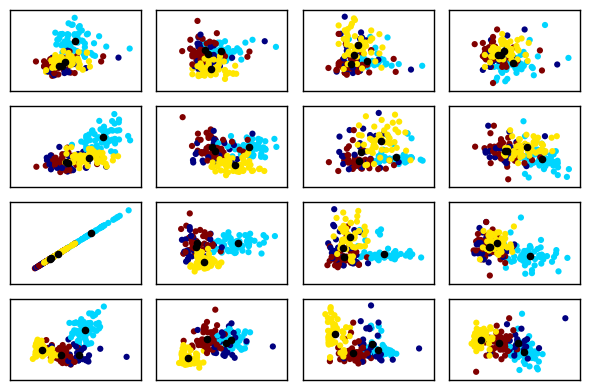

Group: 0 | Size: 26 | Results: {1: 7.6923076923076925, 2: 92.3076923076923, 3: 0.0}
Group: 1 | Size: 59 | Results: {1: 96.61016949152543, 2: 3.389830508474576, 3: 0.0}
Group: 2 | Size: 50 | Results: {1: 0.0, 2: 4.0, 3: 96.0}
Group: 3 | Size: 43 | Results: {1: 0.0, 2: 100.0, 3: 0.0}


In [133]:
originalData = pandas.read_csv('wine/wine.data', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values
analysisData = (analysisData - analysisData.mean(axis=1, keepdims=True)) / (analysisData.max(axis=1, keepdims=True) - analysisData.min(axis=1, keepdims=True))

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(4, analysisData, printInfo=True)

d = analysisData.shape[0]
x = np.random.choice(np.arange(0,d), size=4, replace=False)
y = np.random.choice(np.arange(0,d), size=4, replace=False)
d = 4
for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i*d+j+1)
        plt.scatter(analysisData[x[i], :], analysisData[y[j], :], c=groups, marker='o', lw = 0)
        plt.scatter(centers[x[i],:], centers[y[j],:], c="Black", marker='o', lw = 1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

compareClustersWithResuls(groups, 4, originalData.ix[:,0])

# Breast cancer dataset
Rak może być szkodliwy (M) albo nieszkodliwy (B)

## Dane nieznormalizowane - 2 grupy

Iterations: 8 

Group sizes:
 [438 131] 

Inter cluster distances:
[[  0.00000000e+00   1.77245160e+06]
 [  1.77245160e+06  -1.86264515e-09]] 

Intra cluster average distance to center
 [ 210.67373719  460.85614509] 

Intra cluster maximum distance to center
 [  647.09225651  2862.89023441] 



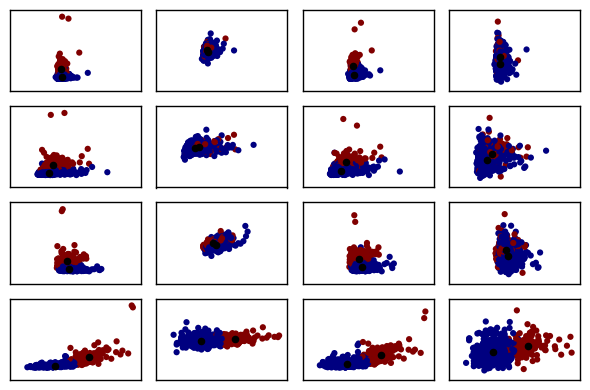

Group: 0 | Size: 438 | Results: {'M': 18.72146118721461, 'B': 81.27853881278538}
Group: 1 | Size: 131 | Results: {'M': 99.23664122137406, 'B': 0.7633587786259542}


In [135]:
originalData = pandas.read_csv('cancer/wdbc.data', sep=',', header=None)
analysisData = originalData.ix[:,2:].T.values

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(2, analysisData, printInfo=True)

d = analysisData.shape[0]
x = np.random.choice(np.arange(0,d), size=4, replace=False)
y = np.random.choice(np.arange(0,d), size=4, replace=False)
d = 4
for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i*d+j+1)
        plt.scatter(analysisData[x[i], :], analysisData[y[j], :], c=groups, marker='o', lw = 0)
        plt.scatter(centers[x[i],:], centers[y[j],:], c="Black", marker='o', lw = 1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

compareClustersWithResuls(groups, 2, originalData.ix[:,1])

## Dane znormalizowane - 2 grupy
Lepiej się pogrupowało

Iterations: 9 

Group sizes:
 [189 380] 

Inter cluster distances:
[[  0.00000000e+00   1.09805666e+00]
 [  1.09805666e+00  -2.77555756e-17]] 

Intra cluster average distance to center
 [ 0.70249908  0.4882462 ] 

Intra cluster maximum distance to center
 [ 2.03438277  1.36791199] 



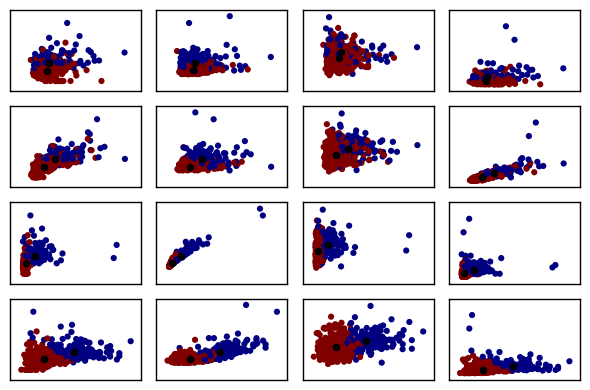

Group: 0 | Size: 189 | Results: {'M': 95.23809523809523, 'B': 4.761904761904762}
Group: 1 | Size: 380 | Results: {'M': 8.421052631578947, 'B': 91.57894736842104}


In [136]:
originalData = pandas.read_csv('cancer/wdbc.data', sep=',', header=None)
analysisData = originalData.ix[:,2:].T.values
analysisData = (analysisData - analysisData.mean(axis=1, keepdims=True)) / (analysisData.max(axis=1, keepdims=True) - analysisData.min(axis=1, keepdims=True))

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(2, analysisData, printInfo=True)

d = analysisData.shape[0]
x = np.random.choice(np.arange(0,d), size=4, replace=False)
y = np.random.choice(np.arange(0,d), size=4, replace=False)
d = 4
for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i*d+j+1)
        plt.scatter(analysisData[x[i], :], analysisData[y[j], :], c=groups, marker='o', lw = 0)
        plt.scatter(centers[x[i],:], centers[y[j],:], c="Black", marker='o', lw = 1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

compareClustersWithResuls(groups, 2, originalData.ix[:,1])

# 3D spatial road network
Dane są segmenty dróg w Północnej Jutlandii w Danii z OpenStreetMap, a konkretnie punkty 3D (wysokość geo, szerokość geo, wysokość). Każdy punkt przynależy do jakiegoś odcinka drogi. Do jednego odcinka może należeć wiele punktów (Ulica nie musi być prosta).

## 5 groups
Punkty podzieliły się wysokościami - pewnie wynika to z tego, że wysokość i szerokość geograficzna nie mają dużych rozrzutów w porównaniu do wysokości, która w takim wypadku stanowi decydujący czynnik odległości. W efekcie wykres obszaru tworzy nam poziomicę.

Iterations: 76 

Group sizes:
 [ 21066  92527 113863  51648 155770] 

Inter cluster distances:
[[  3.63797881e-12   1.77526052e+03   3.08850953e+03   6.09689271e+02
    4.54519831e+03]
 [  1.77526052e+03  -1.81898940e-12   1.80655793e+02   3.04225722e+02
    6.39409863e+02]
 [  3.08850953e+03   1.80655793e+02   9.09494702e-13   9.53738121e+02
    1.40353889e+02]
 [  6.09689271e+02   3.04225722e+02   9.53738121e+02   0.00000000e+00
    1.82559606e+03]
 [  4.54519831e+03   6.39409863e+02   1.40353889e+02   1.82559606e+03
    0.00000000e+00]] 

Intra cluster average distance to center
 [ 8.07081328  3.79953454  3.2984538   5.0200448   2.67923749] 

Intra cluster maximum distance to center
 [ 61.6611525    8.81621626   6.83743568  12.41009168  13.97277811] 



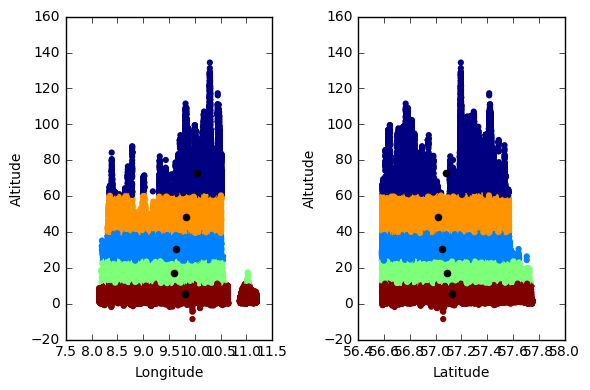

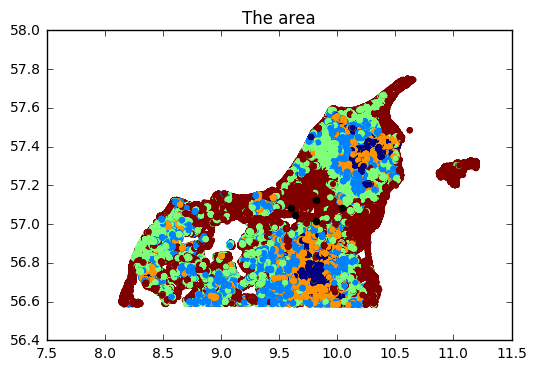

In [107]:
originalData = pandas.read_csv('3dRoadNetwork/3D_spatial_network.txt', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(5, analysisData, printInfo=True)

plt.subplot(1,2,1)
plt.scatter(analysisData[0,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Longitude")
plt.ylabel("Altitude")

plt.subplot(1,2,2)
plt.scatter(analysisData[1,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[1,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Latitude")
plt.ylabel("Altutude")

plt.tight_layout()
plt.show()

plt.scatter(analysisData[0,:], analysisData[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.title("The area")
plt.show()

## 8 groups
Poziomica mniej czytelna, ale bardziej szczegółowa

Iterations: 212 

Group sizes:
 [ 81917  70232 118232  31619   6810  43738  64095  18231] 

Inter cluster distances:
[[  9.09494702e-13   6.50654812e+01   5.76455410e+01   1.47207866e+03
    5.37562638e+03   7.03441122e+02   2.80045172e+02   2.87350809e+03]
 [  6.50654812e+01   0.00000000e+00   2.45190566e+02   9.18306727e+02
    4.25818442e+03   3.40684485e+02   7.51630115e+01   2.07400284e+03]
 [  5.76455410e+01   2.45190566e+02   0.00000000e+00   2.11212006e+03
    6.54615877e+03   1.16372109e+03   5.91754160e+02   3.74481531e+03]
 [  1.47207866e+03   9.18306727e+02   2.11212006e+03   0.00000000e+00
    1.22159961e+03   1.40333283e+02   4.68028605e+02   2.32188682e+02]
 [  5.37562638e+03   4.25818442e+03   6.54615877e+03   1.22159961e+03
    0.00000000e+00   2.18999795e+03   3.20187419e+03   3.88629565e+02]
 [  7.03441122e+02   3.40684485e+02   1.16372109e+03   1.40333283e+02
    2.18999795e+03   0.00000000e+00   9.58086880e+01   7.33536759e+02]
 [  2.80045172e+02   7.51630115e+01  

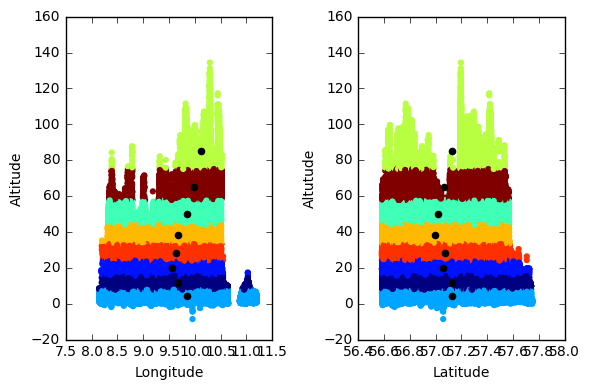

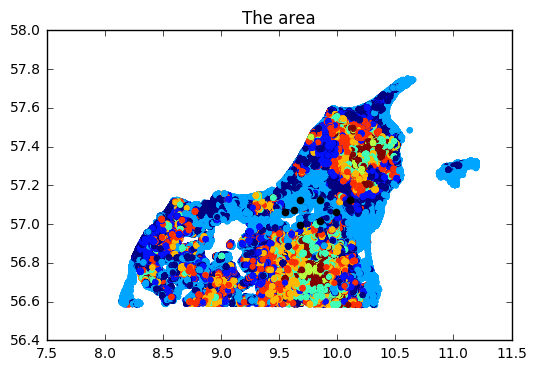

In [108]:
originalData = pandas.read_csv('3dRoadNetwork/3D_spatial_network.txt', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(8, analysisData, printInfo=True)

plt.subplot(1,2,1)
plt.scatter(analysisData[0,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Longitude")
plt.ylabel("Altitude")

plt.subplot(1,2,2)
plt.scatter(analysisData[1,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[1,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Latitude")
plt.ylabel("Altutude")

plt.tight_layout()
plt.show()

plt.scatter(analysisData[0,:], analysisData[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.title("The area")
plt.show()

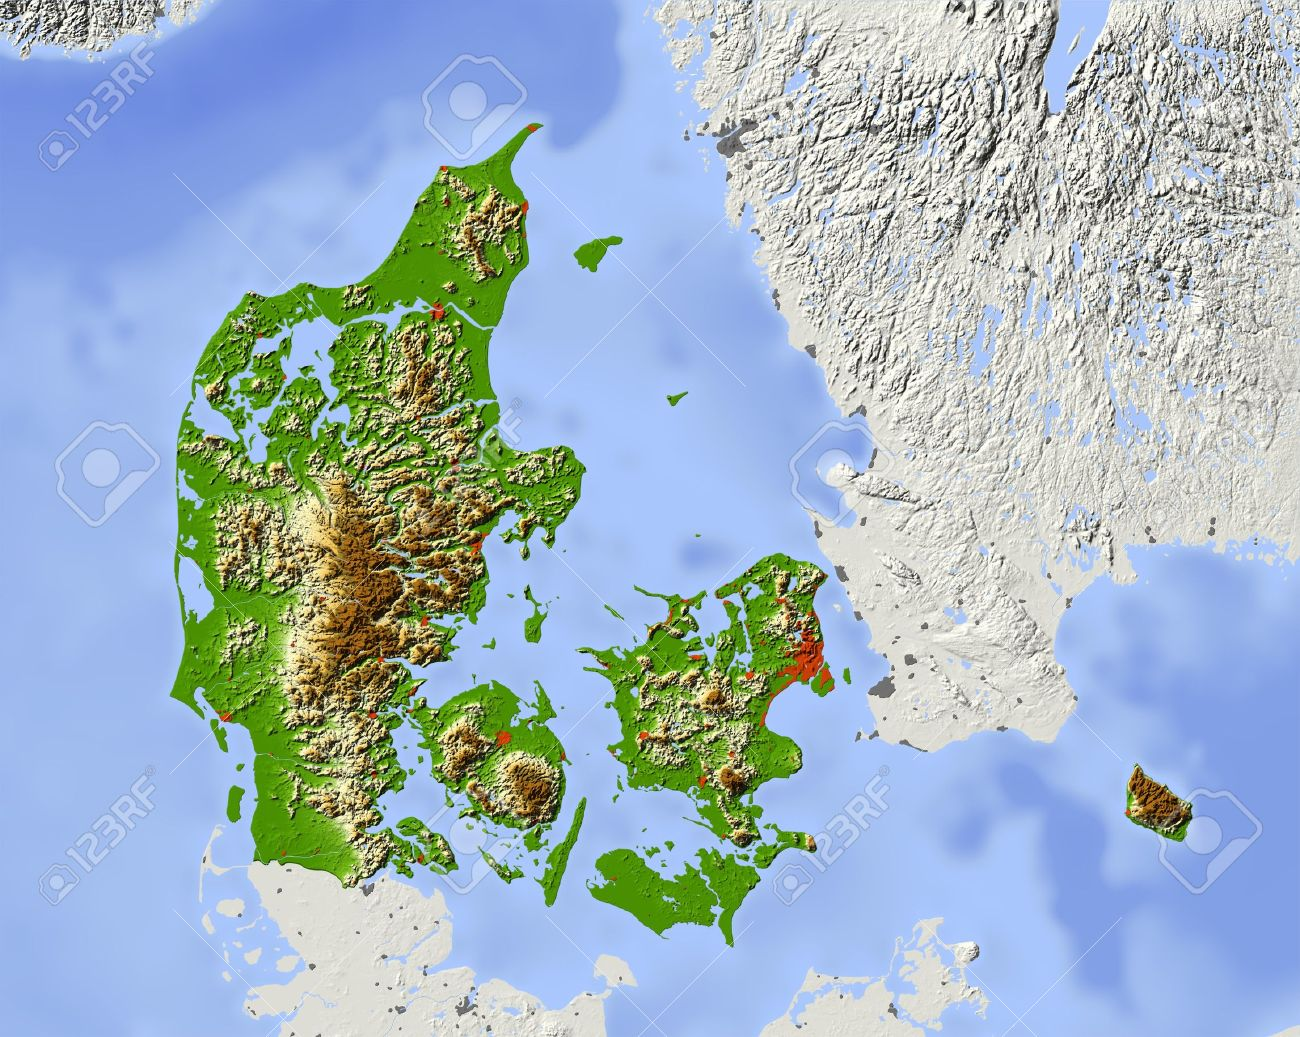

In [110]:
Image(filename="3dRoadNetwork/denmarkMap.jpg")

## Normalized data, 5 groups
Znormalizowaliśmy dane i zobaczmy, co się stanie.

Iterations: 37 

Group sizes:
 [ 95434  67540  64433 125177  82290] 

Inter cluster distances:
[[  0.00000000e+00   4.35012322e-01   6.18539412e-01   1.63939641e-01
    1.37428105e-01]
 [  4.35012322e-01   0.00000000e+00   7.24089782e-02   1.12684299e-01
    2.90868143e-01]
 [  6.18539412e-01   7.24089782e-02   0.00000000e+00   1.61995825e-01
    4.65990367e-01]
 [  1.63939641e-01   1.12684299e-01   1.61995825e-01   1.73472348e-18
    1.05369342e-01]
 [  1.37428105e-01   2.90868143e-01   4.65990367e-01   1.05369342e-01
    0.00000000e+00]] 

Intra cluster average distance to center
 [ 0.16715693  0.15751656  0.14379078  0.14201357  0.17470718] 

Intra cluster maximum distance to center
 [ 0.49101996  0.67550705  0.30670126  0.3713128   0.52188968] 



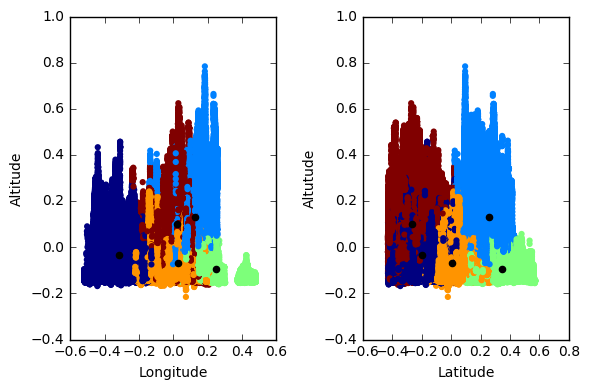

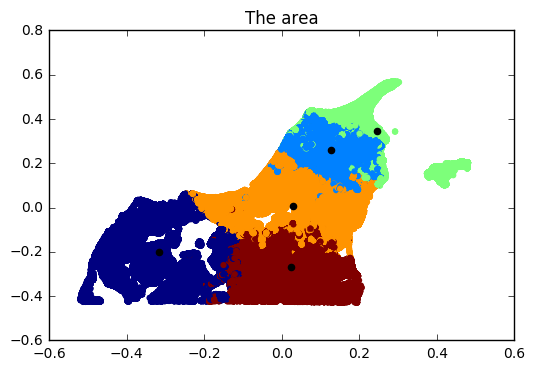

In [104]:
originalData = pandas.read_csv('3dRoadNetwork/3D_spatial_network.txt', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values
analysisData = (analysisData - analysisData.mean(axis=1, keepdims=True)) / (analysisData.max(axis=1, keepdims=True) - analysisData.min(axis=1, keepdims=True))

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(5, analysisData, printInfo=True)

plt.subplot(1,2,1)
plt.scatter(analysisData[0,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Longitude")
plt.ylabel("Altitude")

plt.subplot(1,2,2)
plt.scatter(analysisData[1,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[1,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Latitude")
plt.ylabel("Altutude")

plt.tight_layout()
plt.show()

plt.scatter(analysisData[0,:], analysisData[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.title("The area")
plt.show()

## Normalized data, 8 groups
Wyszedł zwykły K-Means na 8 obszarów i tyle.

Iterations: 54 

Group sizes:
 [41380 48219 53126 40133 54332 32458 41139 79840 21313 22934] 

Inter cluster distances:
[[  0.00000000e+00   3.27353511e-01   6.45783423e-01   7.93957043e-02
    6.44127206e-02   4.50089157e-01   8.94877204e-02   1.37663932e-01
    4.66634329e-01   7.34459461e-02]
 [  3.27353511e-01   0.00000000e+00   6.24792766e-02   2.55050882e-01
    3.59269794e-01   8.50535565e-02   1.18768916e-01   7.18019346e-02
    9.22720866e-02   2.83055013e-01]
 [  6.45783423e-01   6.24792766e-02   0.00000000e+00   4.98648409e-01
    7.15500515e-01   1.22962680e-01   3.46892843e-01   2.05758302e-01
    6.94356414e-02   5.00126603e-01]
 [  7.93957043e-02   2.55050882e-01   4.98648409e-01   0.00000000e+00
    2.20897957e-01   2.26190091e-01   1.58407392e-01   1.18391697e-01
    3.29990459e-01   7.32967933e-02]
 [  6.44127206e-02   3.59269794e-01   7.15500515e-01   2.20897957e-01
    0.00000000e+00   5.63828867e-01   6.62258347e-02   2.39520440e-01
    6.37457818e-01   2.52524749e

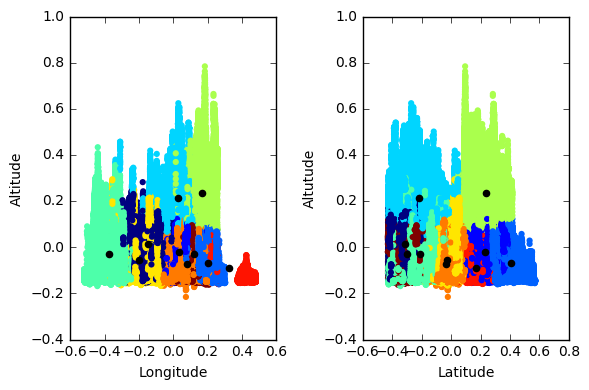

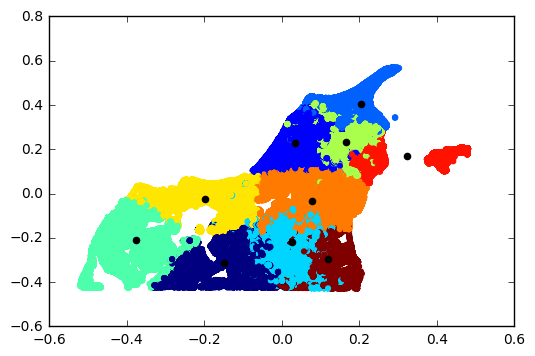

In [103]:
originalData = pandas.read_csv('3dRoadNetwork/3D_spatial_network.txt', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values
analysisData = (analysisData - analysisData.mean(axis=1, keepdims=True)) / (analysisData.max(axis=1, keepdims=True) - analysisData.min(axis=1, keepdims=True))

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(10, analysisData, printInfo=True)

plt.subplot(1,2,1)
plt.scatter(analysisData[0,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Longitude")
plt.ylabel("Altitude")

plt.subplot(1,2,2)
plt.scatter(analysisData[1,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[1,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Latitude")
plt.ylabel("Altutude")

plt.tight_layout()
plt.show()

plt.scatter(analysisData[0,:], analysisData[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

## Normalized only altitude, 10 groups
Obszary ułożyły się względem długości geograficznej, która w największym stopniu wpływa na odległość wektorów.

Iterations: 42 

Group sizes:
 [42015 41486 35608 32912 49842 52766 38505 44892 64018 32830] 

Inter cluster distances:
[[  0.00000000e+00   1.31842011e-01   2.66910392e+00   4.34557218e-01
    7.71162697e-01   3.75698818e-01   5.75791449e-01   1.65005621e+00
    1.84170448e-01   1.93579308e-01]
 [  1.31842011e-01   9.09494702e-13   3.55818533e+00   3.00806836e-01
    1.15316233e+00   1.84057799e-01   5.92165956e-01   2.31174254e+00
    2.39672855e-01   4.89051609e-01]
 [  2.66910392e+00   3.55818533e+00   0.00000000e+00   2.95714825e+00
    7.36154730e-01   4.87161009e+00   1.75351308e+00   1.48110531e-01
    2.22322411e+00   1.50142005e+00]
 [  4.34557218e-01   3.00806836e-01   2.95714825e+00  -9.09494702e-13
    7.45760681e-01   5.58244323e-01   2.38955595e-01   1.78174256e+00
    9.71559283e-02   4.28461541e-01]
 [  7.71162697e-01   1.15316233e+00   7.36154730e-01   7.45760681e-01
    0.00000000e+00   1.94084584e+00   2.57823109e-01   2.24386883e-01
    4.11433606e-01   2.05071616e

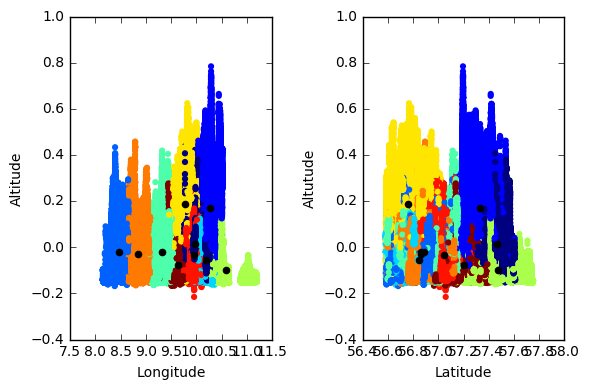

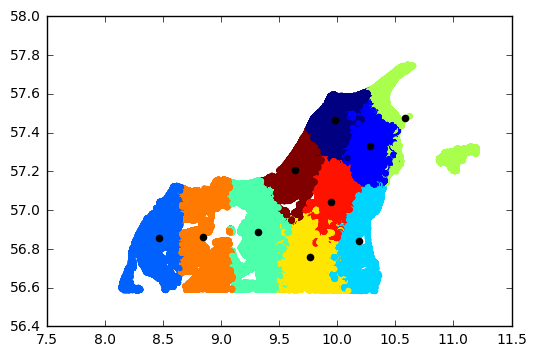

In [113]:
originalData = pandas.read_csv('3dRoadNetwork/3D_spatial_network.txt', sep=',', header=None)
analysisData = originalData.ix[:,1:].T.values
analysisData[2,:] = (analysisData[2,:] - analysisData[2,:].mean()) / (analysisData[2,:].max() - analysisData[2,:].min())

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(10, analysisData, printInfo=True)

plt.subplot(1,2,1)
plt.scatter(analysisData[0,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Longitude")
plt.ylabel("Altitude")

plt.subplot(1,2,2)
plt.scatter(analysisData[1,:], analysisData[2,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[1,:], centers[2,:], c="Black", marker='o', lw = 1)
plt.xlabel("Latitude")
plt.ylabel("Altutude")

plt.tight_layout()
plt.show()

plt.scatter(analysisData[0,:], analysisData[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

# Gestures grouping
Ludzie komunikując się, posługują się gestami. Zmierzono pozycje dłoni, nadgarstków głowy oraz kręgosłupa(?) w trakcie opowiadania historii przez człowieka. Następnie pozycje zamieniono pozycje na prędkości i przyspieszenia odpowiednich części ciał. Grupowanie przez autorów datasetu podzieliło gesty na kategorie: 
<ul>
<li>Spoczynek - Rest(D)</li> 
<li>Ruch ręką - Stroke(S)</li> 
<li>Trzymanie w miejscu (Pewnie rąk) - Hold(H)</li>
<li>Przygotowanie - Preparation(P)</li>
<li>Wycofanie - Retraction(R)</li>
</ul>

## 5 groups
Since we distinguish 5 types of gestures, we can try to run K-Means with K=5

In [137]:
originalData = pandas.read_csv('gestures/a1_va3.csv', sep=',', header=0)
analysisData = originalData.ix[:,:32].T.values

groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(5, analysisData, printInfo=True)

compareClustersWithResuls(groups, 5, originalData.ix[:,32])

Iterations: 16 

Group sizes:
 [1285  123  210    8  117] 

Inter cluster distances:
[[  5.42101086e-20   3.88405739e-03   1.11007242e-03   3.46481693e-02
    4.12369698e-03]
 [  3.88405739e-03   0.00000000e+00   3.26301207e-03   2.72803837e-02
    6.44980835e-03]
 [  1.11007242e-03   3.26301207e-03   0.00000000e+00   2.37703454e-02
    3.73413655e-03]
 [  3.46481693e-02   2.72803837e-02   2.37703454e-02   0.00000000e+00
    3.17081508e-02]
 [  4.12369698e-03   6.44980835e-03   3.73413655e-03   3.17081508e-02
    0.00000000e+00]] 

Intra cluster average distance to center
 [ 0.01848855  0.05402852  0.03372253  0.10027534  0.05549118] 

Intra cluster maximum distance to center
 [ 0.0753829   0.1189579   0.08282306  0.18357678  0.1438722 ] 

Group: 0 | Size: 1285 | Results: {'R': 12.217898832684826, 'S': 24.669260700389106, 'D': 52.06225680933852, 'P': 8.249027237354086, 'H': 2.801556420233463}
Group: 1 | Size: 123 | Results: {'R': 4.878048780487805, 'S': 84.55284552845528, 'D': 0.0, 'P'

## 8 groups
We have managed to find one distinguishable group of strokes, we can try to dig deeper.

Wyraźna różnica miedzy grupą 2 a 7 -- jedna to ruchy (Strokes i Preparation), druga to spoczynek (trochę Strokes i Rest)

In [141]:
originalData = pandas.read_csv('gestures/a1_va3.csv', sep=',', header=0)
analysisData = originalData.ix[:,:32].T.values

K = 8
groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, analysisData, printInfo=True)

compareClustersWithResuls(groups, K, originalData.ix[:,32])

Iterations: 25 

Group sizes:
 [  43   45   38   70  152  191  188 1016] 

Inter cluster distances:
[[  0.00000000e+00   9.10533677e-03   1.65266218e-02   5.12646342e-03
    6.45989759e-03   4.63629099e-03   7.44824922e-03   7.50720615e-03]
 [  9.10533677e-03   0.00000000e+00   1.01693161e-02   1.16338810e-02
    7.05019231e-03   4.48112550e-03   5.87131126e-03   7.61617140e-03]
 [  1.65266218e-02   1.01693161e-02  -3.46944695e-18   7.56200589e-03
    6.57913561e-03   1.07382987e-02   6.92577597e-03   1.07437757e-02]
 [  5.12646342e-03   1.16338810e-02   7.56200589e-03   0.00000000e+00
    3.70354250e-03   4.91342072e-03   3.16451466e-03   4.69998458e-03]
 [  6.45989759e-03   7.05019231e-03   6.57913561e-03   3.70354250e-03
    4.33680869e-19   1.94936613e-03   1.23919764e-03   1.21965162e-03]
 [  4.63629099e-03   4.48112550e-03   1.07382987e-02   4.91342072e-03
    1.94936613e-03   8.67361738e-19   1.21168041e-03   1.10261541e-03]
 [  7.44824922e-03   5.87131126e-03   6.92577597e-03  

## 15 groups
Holdy są praktycznie niewykrywalne - pewnie dlatego, że jest ich mało, oraz łatwo je pomylić ze spoczynkiem. Im więcej grup, tym mogę łatwiej wyłaniać grupy specjalne. Pojawia się co raz więcej grup, które są jednocześnie Stroke i Retraction oraz Preparation i Stroke. Pewnie przygotowanie i wycofanie wyglądają podobnie do siebie oraz łatwo się mieszają z ruchem - stąd są wymieszane ze strokami.

In [142]:
originalData = pandas.read_csv('gestures/a1_va3.csv', sep=',', header=0)
analysisData = originalData.ix[:,:32].T.values

K = 15
groups, centers, interCluster, intraClusterAvg, intraClusterMax = KMeans(K, analysisData, printInfo=True)

compareClustersWithResuls(groups, K, originalData.ix[:,32])

Iterations: 24 

Group sizes:
 [ 11  53  78  34 124 171  69 783  66  74  35  35  25 122  63] 

Inter cluster distances:
[[ -6.93889390e-18   1.61353611e-02   2.09351694e-02   2.57415904e-02
    2.58958454e-02   2.68286200e-02   2.87483871e-02   2.77667930e-02
    2.30059384e-02   2.77274382e-02   2.89430528e-02   2.77563663e-02
    1.85694078e-02   1.95032650e-02   1.79787636e-02]
 [  1.61353611e-02   5.20417043e-18   3.01897468e-03   7.62331679e-03
    6.20069871e-03   5.14831710e-03   6.93493607e-03   6.05770297e-03
    6.25890811e-03   4.42178974e-03   1.40365865e-02   6.44058000e-03
    1.07656501e-02   4.73364957e-03   3.45592413e-03]
 [  2.09351694e-02   3.01897468e-03   4.33680869e-19   3.33237231e-03
    1.03165523e-03   1.26394769e-03   2.49433356e-03   1.21527145e-03
    1.76884420e-03   2.33378712e-03   7.61141815e-03   6.08651690e-03
    9.21951094e-03   1.15908868e-03   1.72185891e-03]
 [  2.57415904e-02   7.62331679e-03   3.33237231e-03  -8.67361738e-19
    1.49821844e-03